# Machine Learning in Python - Project 2

Due Wednesday, April 15th by 5 pm.

## 1. Setup

### 1.1 Libraries

In [1]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

import warnings
warnings.filterwarnings("ignore")
# sklearn modules
import sklearn
import os
os.environ['KERAS_BACKEND']='tensorflow'
from imblearn.over_sampling import RandomOverSampler

Using TensorFlow backend.


### 1.2 Data

In [2]:
wine_train = pd.read_csv("wine_qual_train.csv")
wine_test  = pd.read_csv("wine_qual_test.csv")

## 2. Exploratory Data Analysis and Preprocessing

*Include a discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up.*

*In this section you should also implement and describe any preprocessing / transformations of the features. Hint - you need to take care of the discretization of the `quality` variable as described in `README.ipynb`.*

包括对数据的讨论，特别强调与后续建模相关的数据特征。 强烈建议将数据可视化包括在内-所有代码和图也必须在编写中进行描述。

在本节中，您还应该实现和描述功能的任何预处理/转换。 提示-您需要注意README.ipynb中描述的质量变量的离散化。

## 先对数据进行预处理

In [3]:
# describe
wine_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 13 columns):
quality                 3000 non-null int64
wine                    3000 non-null object
fixed_acidity           3000 non-null float64
volatile_acidity        3000 non-null float64
citric_acid             3000 non-null float64
residual_sugar          3000 non-null float64
chlorides               3000 non-null float64
free_sulfur_dioxide     3000 non-null float64
total_sulfur_dioxide    3000 non-null float64
density                 3000 non-null float64
p_h                     3000 non-null float64
sulphates               3000 non-null float64
alcohol                 3000 non-null float64
dtypes: float64(11), int64(1), object(1)
memory usage: 304.8+ KB


In [4]:
# 缺失值判断
wine_train.isnull().sum()

quality                 0
wine                    0
fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
p_h                     0
sulphates               0
alcohol                 0
dtype: int64

In [5]:
# 针对 object的形式进行分析
wine_train['wine'].value_counts()

white    2254
red       746
Name: wine, dtype: int64

训练数据中不存在缺失值，下一步进行异常值可视化

In [6]:
wine_train.describe()

,quality,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,p_h,sulphates,alcohol
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,5.793333,7.227633,0.340667,0.319857,5.543033,0.056370,30.894833,115.797500,0.994740,3.215623,0.530207,10.486753
std,0.846283,1.309546,0.163205,0.147306,4.851228,0.034987,17.871765,56.847462,0.003071,0.159478,0.143235,1.196064
min,3.000000,3.900000,0.105000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.740000,0.220000,8.000000
25%,5.000000,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,76.000000,0.992340,3.110000,0.430000,9.500000
50%,6.000000,7.000000,0.290000,0.310000,3.050000,0.048000,29.000000,118.000000,0.994980,3.200000,0.510000,10.300000
75%,6.000000,7.700000,0.410000,0.400000,8.200000,0.066000,42.000000,156.000000,0.997000,3.320000,0.600000,11.300000
max,9.000000,15.900000,1.330000,1.660000,65.800000,0.611000,146.500000,307.500000,1.038980,4.010000,2.000000,14.900000


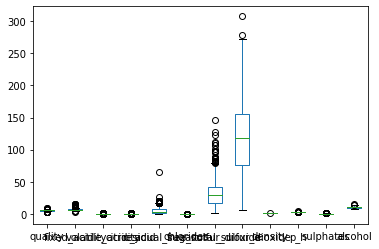

In [7]:
wine_train.plot.box()

通过上述数据初步的describe和箱线图，可以观察到训练数据中存在很多异常值，所以在此考虑对数据进行第一次清洗


In [8]:
from operator import itemgetter

In [9]:
# 这里我包装了一个异常值处理的代码，可以随便调用。
def outliers_proc(data, col_name, scale=3):
    """
    用于清洗异常值，默认用 box_plot（scale=3）进行清洗
    :param data: 接收 pandas 数据格式
    :param col_name: pandas 列名
    :param scale: 尺度
    :return:
    """

    def box_plot_outliers(data_ser, box_scale):
        """
        利用箱线图去除异常值
        :param data_ser: 接收 pandas.Series 数据格式
        :param box_scale: 箱线图尺度，
        :return:
        """
        iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
        val_low = data_ser.quantile(0.25) - iqr
        val_up = data_ser.quantile(0.75) + iqr
        rule_low = (data_ser < val_low)
        rule_up = (data_ser > val_up)
        return (rule_low, rule_up), (val_low, val_up)

    data_n = data.copy()
    data_series = data_n[col_name]
    rule, value = box_plot_outliers(data_series, box_scale=scale)
    index = np.arange(data_series.shape[0])[rule[0] | rule[1]]
    print("Delete number is: {}".format(len(index)))
    data_n = data_n.drop(index)
    data_n.reset_index(drop=True, inplace=True)
    print("Now column number is: {}".format(data_n.shape[0]))
    index_low = np.arange(data_series.shape[0])[rule[0]]
    outliers = data_series.iloc[index_low]
    print("Description of data less than the lower bound is:")
    print(pd.Series(outliers).describe())
    index_up = np.arange(data_series.shape[0])[rule[1]]
    outliers = data_series.iloc[index_up]
    print("Description of data larger than the upper bound is:")
    print(pd.Series(outliers).describe())
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 7))
    sns.boxplot(y=data[col_name], data=data, palette="Set1", ax=ax[0])
    sns.boxplot(y=data_n[col_name], data=data_n, palette="Set1", ax=ax[1])
    return data_n

In [10]:
train_data = wine_train
train_data.describe()

,quality,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,p_h,sulphates,alcohol
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,5.793333,7.227633,0.340667,0.319857,5.543033,0.056370,30.894833,115.797500,0.994740,3.215623,0.530207,10.486753
std,0.846283,1.309546,0.163205,0.147306,4.851228,0.034987,17.871765,56.847462,0.003071,0.159478,0.143235,1.196064
min,3.000000,3.900000,0.105000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.740000,0.220000,8.000000
25%,5.000000,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,76.000000,0.992340,3.110000,0.430000,9.500000
50%,6.000000,7.000000,0.290000,0.310000,3.050000,0.048000,29.000000,118.000000,0.994980,3.200000,0.510000,10.300000
75%,6.000000,7.700000,0.410000,0.400000,8.200000,0.066000,42.000000,156.000000,0.997000,3.320000,0.600000,11.300000
max,9.000000,15.900000,1.330000,1.660000,65.800000,0.611000,146.500000,307.500000,1.038980,4.010000,2.000000,14.900000


Delete number is: 39
Now column number is: 2961
Description of data less than the lower bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fixed_acidity, dtype: float64
Description of data larger than the upper bound is:
count    39.000000
mean     12.720513
std       1.120897
min      11.700000
25%      11.900000
50%      12.400000
75%      12.850000
max      15.900000
Name: fixed_acidity, dtype: float64
Delete number is: 13
Now column number is: 2948
Description of data less than the lower bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: volatile_acidity, dtype: float64
Description of data larger than the upper bound is:
count    13.000000
mean      1.040385
std       0.105780
min       0.935000
25%       0.965000
50%       1.005000
75%       1.090000
max       1.330000
Name: volatile_acidity, dtype: float64
Delete number is: 7
Now column number 

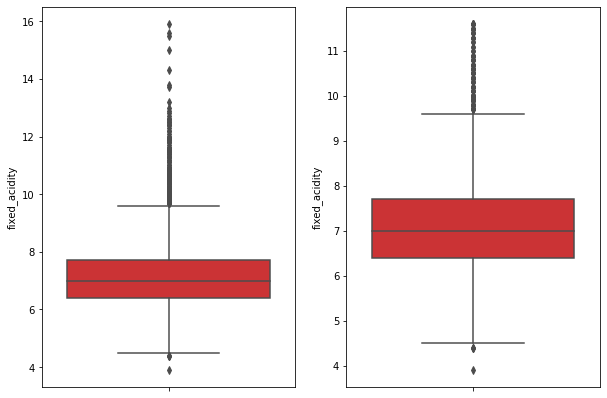

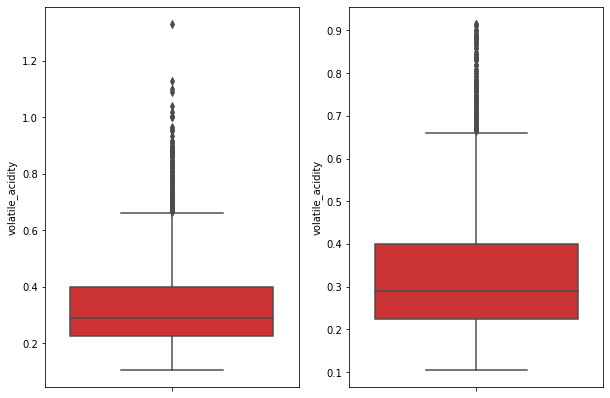

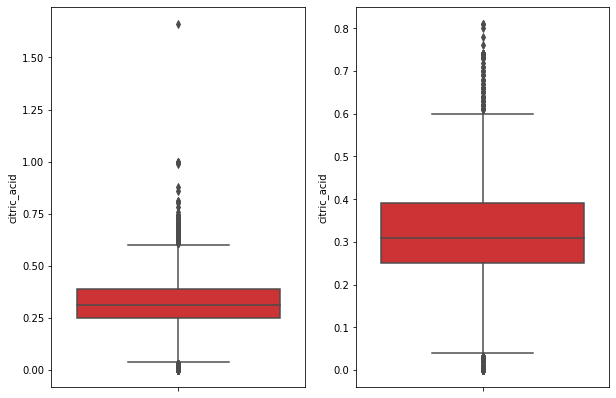

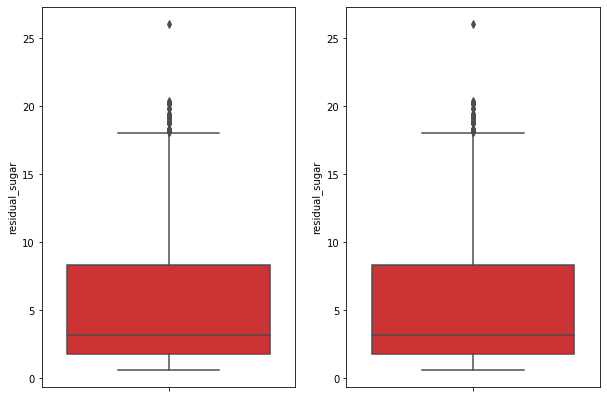

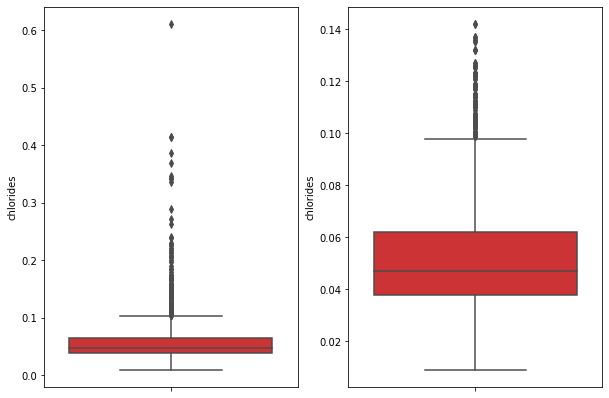

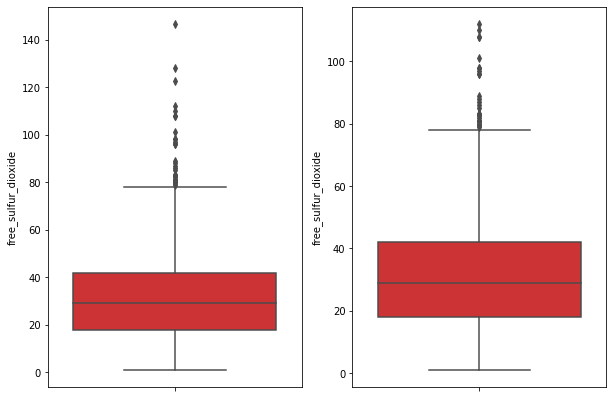

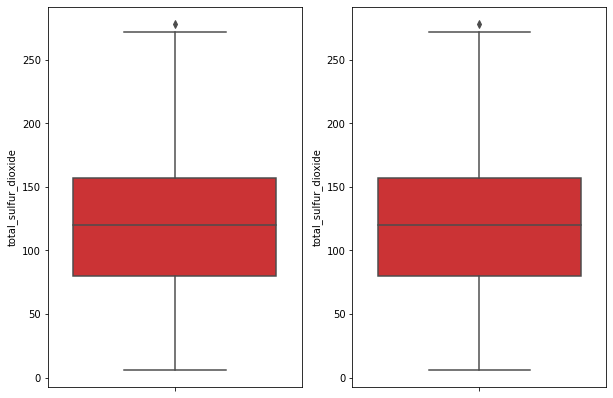

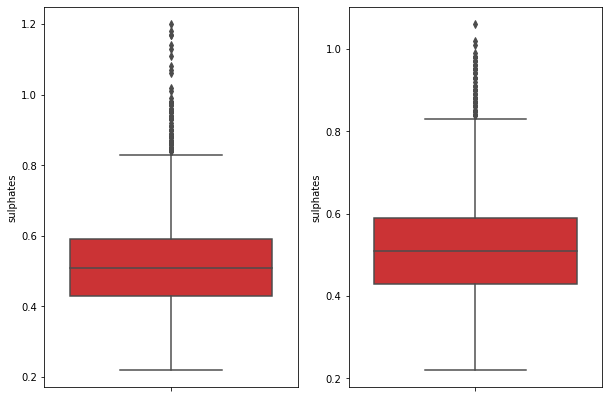

In [11]:
for i in ["fixed_acidity","volatile_acidity","citric_acid","residual_sugar","chlorides","free_sulfur_dioxide","total_sulfur_dioxide","sulphates"]:
    train_data = outliers_proc(train_data, i, scale=3)

In [12]:
train_data.describe()

,quality,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,p_h,sulphates,alcohol
count,2872.000000,2872.000000,2872.000000,2872.000000,2872.000000,2872.000000,2872.000000,2872.000000,2872.000000,2872.000000,2872.000000,2872.000000
mean,5.807799,7.132451,0.333296,0.313639,5.605658,0.052329,31.233635,117.594359,0.994607,3.218123,0.522552,10.504600
std,0.843750,1.128200,0.155058,0.137977,4.753966,0.020874,17.481485,55.952616,0.002909,0.159443,0.130056,1.199094
min,3.000000,3.900000,0.105000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.770000,0.220000,8.000000
25%,5.000000,6.400000,0.220000,0.250000,1.800000,0.038000,18.000000,80.000000,0.992215,3.110000,0.430000,9.500000
50%,6.000000,7.000000,0.290000,0.310000,3.200000,0.047000,29.000000,120.000000,0.994820,3.210000,0.510000,10.300000
75%,6.000000,7.600000,0.400000,0.390000,8.325000,0.062000,42.000000,157.000000,0.996900,3.320000,0.590000,11.300000
max,9.000000,11.600000,0.915000,0.810000,26.050000,0.142000,112.000000,278.000000,1.002950,4.010000,1.060000,14.200000


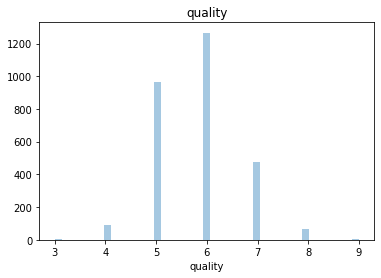

In [13]:
## 1) quality总体分布概况
import scipy.stats as st
y = train_data['quality']
plt.figure(1); plt.title('quality')
sns.distplot(y, kde=False)

quality 符合正态分布

In [14]:
train_data.describe()

,quality,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,p_h,sulphates,alcohol
count,2872.000000,2872.000000,2872.000000,2872.000000,2872.000000,2872.000000,2872.000000,2872.000000,2872.000000,2872.000000,2872.000000,2872.000000
mean,5.807799,7.132451,0.333296,0.313639,5.605658,0.052329,31.233635,117.594359,0.994607,3.218123,0.522552,10.504600
std,0.843750,1.128200,0.155058,0.137977,4.753966,0.020874,17.481485,55.952616,0.002909,0.159443,0.130056,1.199094
min,3.000000,3.900000,0.105000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.770000,0.220000,8.000000
25%,5.000000,6.400000,0.220000,0.250000,1.800000,0.038000,18.000000,80.000000,0.992215,3.110000,0.430000,9.500000
50%,6.000000,7.000000,0.290000,0.310000,3.200000,0.047000,29.000000,120.000000,0.994820,3.210000,0.510000,10.300000
75%,6.000000,7.600000,0.400000,0.390000,8.325000,0.062000,42.000000,157.000000,0.996900,3.320000,0.590000,11.300000
max,9.000000,11.600000,0.915000,0.810000,26.050000,0.142000,112.000000,278.000000,1.002950,4.010000,1.060000,14.200000


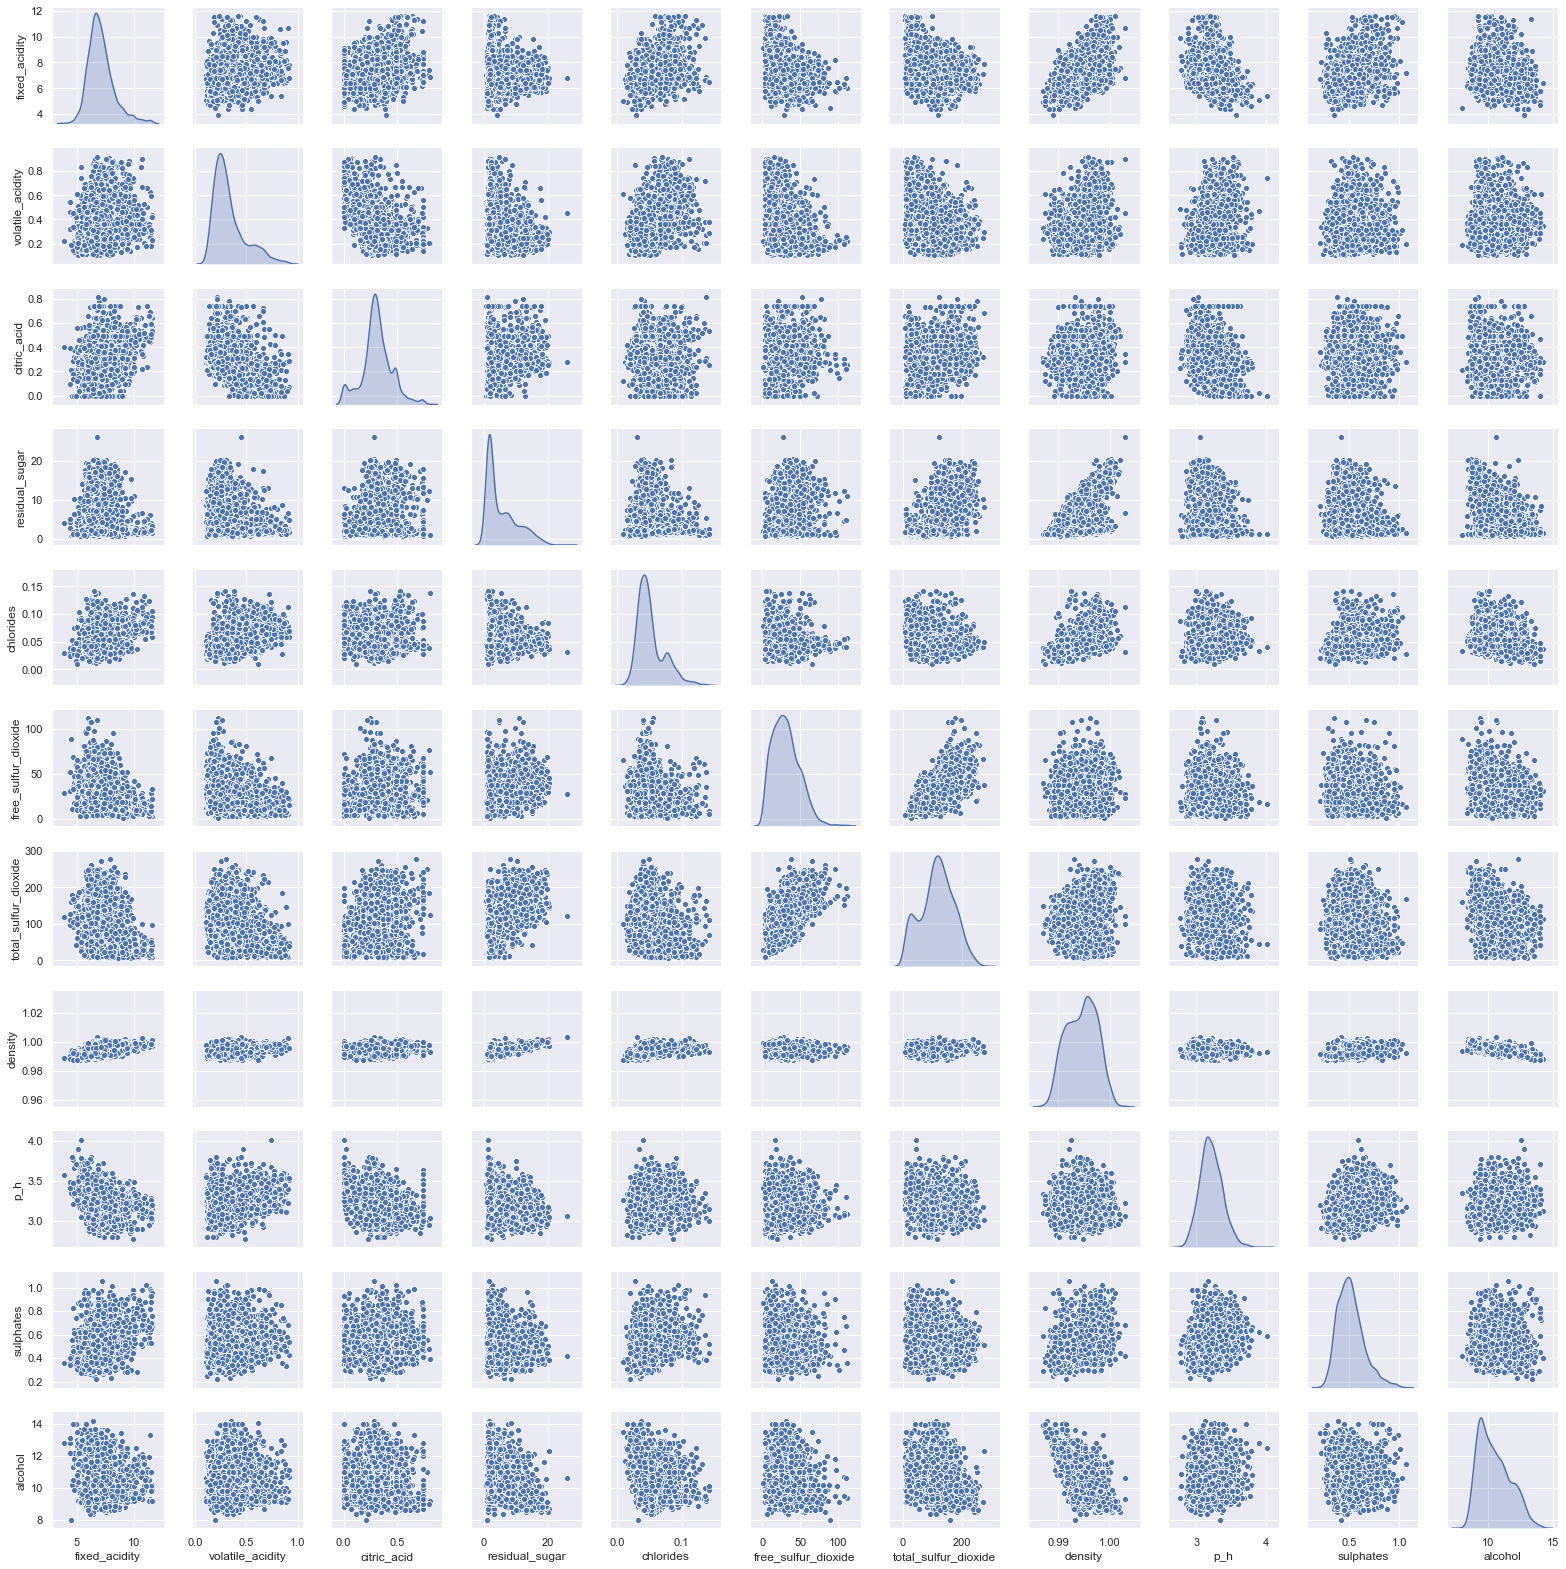

In [15]:
## 2) 统一绘制数字特征相互之间的关系可视化
sns.set()
columns = ['fixed_acidity', 'volatile_acidity', 'citric_acid' , 'residual_sugar', 'chlorides', 'free_sulfur_dioxide',  'total_sulfur_dioxide',
           'density', 'p_h', 'sulphates','alcohol']
sns.pairplot(train_data[columns],size = 2 ,kind ='scatter',diag_kind='kde')
plt.show()

从上述各图可以看出并没有某数据出现非常严重的偏移，并且各变量间的影响关系也较小。

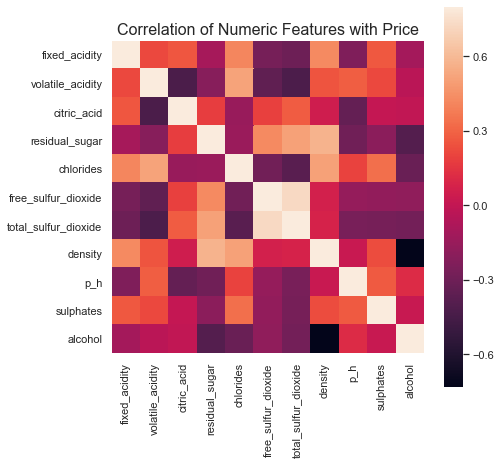

In [16]:
## 3) 数字特征相关性分析
columns = ['fixed_acidity', 'volatile_acidity', 'citric_acid' , 'residual_sugar', 'chlorides', 'free_sulfur_dioxide',  'total_sulfur_dioxide',
           'density', 'p_h', 'sulphates','alcohol']
correlation = train_data[columns].corr()
f , ax = plt.subplots(figsize = (7, 7))

plt.title('Correlation of Numeric Features with Price',y=1,size=16)

sns.heatmap(correlation,square = True,  vmax=0.8)

In [17]:
train_data[columns].corr()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,p_h,sulphates,alcohol
fixed_acidity,1.000000,0.217909,0.257360,-0.099000,0.412096,-0.266793,-0.303497,0.424817,-0.240572,0.261838,-0.108992
volatile_acidity,0.217909,1.000000,-0.433065,-0.209023,0.513292,-0.351678,-0.422966,0.254184,0.280696,0.216642,-0.032196
citric_acid,0.257360,-0.433065,1.000000,0.177667,-0.146664,0.194304,0.275630,0.050090,-0.334008,0.005488,-0.007838
residual_sugar,-0.099000,-0.209023,0.177667,1.000000,-0.146240,0.424080,0.512395,0.574834,-0.292164,-0.194476,-0.395425
chlorides,0.412096,0.513292,-0.146664,-0.146240,1.000000,-0.287173,-0.378257,0.510340,0.199749,0.336153,-0.318846
free_sulfur_dioxide,-0.266793,-0.351678,0.194304,0.424080,-0.287173,1.000000,0.723132,0.066183,-0.163223,-0.170980,-0.178531
total_sulfur_dioxide,-0.303497,-0.422966,0.275630,0.512395,-0.378257,0.723132,1.000000,0.079717,-0.262256,-0.267502,-0.280351
density,0.424817,0.254184,0.050090,0.574834,0.510340,0.066183,0.079717,1.000000,0.024403,0.225076,-0.733437
p_h,-0.240572,0.280696,-0.334008,-0.292164,0.199749,-0.163223,-0.262256,0.024403,1.000000,0.271622,0.113454
sulphates,0.261838,0.216642,0.005488,-0.194476,0.336153,-0.170980,-0.267502,0.225076,0.271622,1.000000,0.018740


In [18]:
# 葡萄酒质量分类  质量变量的离散化
# Excellent 记为 4 Good记为 3  Average 记为 2 Poor记为1
list_1 = []
list_2 = []
for i in range(len(train_data['quality'])):
    if train_data['quality'][i] >= 7:
        list_1.append("Excellent")
        list_2.append(4)
    elif train_data['quality'][i] == 6:
        list_1.append("Good")
        list_2.append(3)
    elif train_data['quality'][i] == 5:
        list_1.append("Average")
        list_2.append(2)
    else:
        list_1.append("Poor")
        list_2.append(1)

In [19]:
train_data['Qua'] = list_2
train_data.head()

,quality,wine,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,p_h,sulphates,alcohol,Qua
0,7,white,7.5,0.23,0.49,7.7,0.049,61.0,209.0,0.99410,3.14,0.30,11.1,4
1,5,red,6.9,0.52,0.25,2.6,0.081,10.0,37.0,0.99685,3.46,0.50,11.0,2
2,6,red,7.7,0.61,0.18,2.4,0.083,6.0,20.0,0.99630,3.29,0.60,10.2,3
3,6,white,7.1,0.38,0.29,13.6,0.041,30.0,137.0,0.99461,3.02,0.96,12.1,3
4,6,white,6.8,0.21,0.42,1.2,0.045,24.0,126.0,0.99234,3.09,0.87,10.9,3


In [20]:
test_data = wine_test

In [21]:
# 葡萄酒质量分类  质量变量的离散化
# Excellent 记为 4 Good记为 3  Average 记为 2 Poor记为1
list_3 = []
list_4 = []
for i in range(len(test_data['quality'])):
    if test_data['quality'][i] >= 7:
        list_3.append("Excellent")
        list_4.append(4)
    elif test_data['quality'][i] == 6:
        list_3.append("Good")
        list_4.append(3)
    elif test_data['quality'][i] == 5:
        list_3.append("Average")
        list_4.append(2)
    else:
        list_3.append("Poor")
        list_4.append(1)

In [22]:
test_data['Qua'] = list_4
test_data.head()

,quality,wine,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,p_h,sulphates,alcohol,Qua
0,5,red,10.0,0.350,0.45,2.5,0.092,20.0,88.0,0.99918,3.15,0.43,9.4,2
1,4,red,7.6,0.680,0.02,1.3,0.072,9.0,20.0,0.99650,3.17,1.08,9.2,1
2,7,white,6.8,0.180,0.28,9.8,0.039,29.0,113.0,0.99406,3.11,0.45,10.9,4
3,6,red,6.8,0.785,0.00,2.4,0.104,14.0,30.0,0.99660,3.52,0.55,10.7,3
4,5,red,6.6,0.880,0.04,2.2,0.066,12.0,20.0,0.99636,3.53,0.56,9.9,2


In [23]:
# One-hot编码处理 wine 得到最终可用数据集  训练集 和 测试集 做同样的操作
train_data = pd.get_dummies(train_data,columns=[ 'wine'],dtype='int')  
test_data = pd.get_dummies(test_data,columns=[ 'wine'],dtype='int')  

In [24]:
# 删去对训练模型无用的特征
del train_data['quality']
del test_data['quality']

In [25]:
train_data.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,p_h,sulphates,alcohol,Qua,wine_red,wine_white
0,7.5,0.23,0.49,7.7,0.049,61.0,209.0,0.99410,3.14,0.30,11.1,4,0,1
1,6.9,0.52,0.25,2.6,0.081,10.0,37.0,0.99685,3.46,0.50,11.0,2,1,0
2,7.7,0.61,0.18,2.4,0.083,6.0,20.0,0.99630,3.29,0.60,10.2,3,1,0
3,7.1,0.38,0.29,13.6,0.041,30.0,137.0,0.99461,3.02,0.96,12.1,3,0,1
4,6.8,0.21,0.42,1.2,0.045,24.0,126.0,0.99234,3.09,0.87,10.9,3,0,1


In [26]:
test_data.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,p_h,sulphates,alcohol,Qua,wine_red,wine_white
0,10.0,0.350,0.45,2.5,0.092,20.0,88.0,0.99918,3.15,0.43,9.4,2,1,0
1,7.6,0.680,0.02,1.3,0.072,9.0,20.0,0.99650,3.17,1.08,9.2,1,1,0
2,6.8,0.180,0.28,9.8,0.039,29.0,113.0,0.99406,3.11,0.45,10.9,4,0,1
3,6.8,0.785,0.00,2.4,0.104,14.0,30.0,0.99660,3.52,0.55,10.7,3,1,0
4,6.6,0.880,0.04,2.2,0.066,12.0,20.0,0.99636,3.53,0.56,9.9,2,1,0


在这里基本的数据预处理的工作就全部完成了，进一步的，我们发现wine中一共有两个品种的酒，red and  white 这里考虑将其分开，分别得到数据集

In [27]:
# 得到训练集的 白酒红酒数据集
group_train_red = train_data.groupby('wine_red')
Red_train_data = group_train_red.get_group(1).reset_index()
group_train_white = train_data.groupby('wine_white')
White_train_data = group_train_white.get_group(1).reset_index()

In [28]:
# 得到测试集的 白酒红酒数据集
group_test_red = test_data.groupby('wine_red')
Red_test_data = group_test_red.get_group(1).reset_index()
group_test_white = test_data.groupby('wine_white')
White_test_data = group_test_white.get_group(1).reset_index()

In [29]:
# 删去无用的特征
del Red_train_data['wine_red']
del Red_train_data['wine_white']
del White_train_data['wine_red']
del White_train_data['wine_white']

In [30]:
Red_train_data.head()

,index,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,p_h,sulphates,alcohol,Qua
0,1,6.9,0.52,0.25,2.6,0.081,10.0,37.0,0.99685,3.46,0.50,11.0,2
1,2,7.7,0.61,0.18,2.4,0.083,6.0,20.0,0.99630,3.29,0.60,10.2,3
2,11,8.3,0.26,0.42,2.0,0.080,11.0,27.0,0.99740,3.21,0.80,9.4,3
3,12,7.7,0.75,0.27,3.8,0.110,34.0,89.0,0.99664,3.24,0.45,9.3,2
4,13,7.2,0.63,0.00,1.9,0.097,14.0,38.0,0.99675,3.37,0.58,9.0,3


## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model. You are strongly encouraged to explore many different modeling methods (e.g. logistic regression, regression trees, support vector machines, etc.) but you should not include a detailed narrative of all of these attempts. At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using.*

*For example if you considered a logistic regression model, a classification tree, and a support vector machine model and ultimately settled on the logistic regression approach then you should mention that other two approaches were tried but do not include any of the code or any in-depth discussion of these models beyond why they were rejected. Additional code for these models should be included in a supplemental materials notebook. What this section should then detail is the development of the  model of choice in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.*


在本节中，您应该详细介绍模型的选择，并描述用于完善和拟合该模型的过程。强烈建议您探索许多不同的建模方法（例如逻辑回归，回归树，支持向量机等），但您不应该包括所有这些尝试的详细叙述。此部分最多应提及所探索的方法以及拒绝使用它们的原因-您的大部分工作应用于描述所使用的模型。

例如，如果您考虑了逻辑回归模型，分类树和支持向量机模型，并最终选择了逻辑回归方法，则应提及尝试了其他两种方法，但不包括任何代码或任何内部代码。这些模型的深入讨论超出了为什么它们被拒绝的原因。这些模型的附加代码应包含在补充材料笔记本中。然后，本节应该详细介绍所选模型的开发，包括所使用的功能，所考虑的交互以及最终导致最终模型的任何其他调整和验证。

In [31]:
# 构造训练数据
numeric_features = ['fixed_acidity','volatile_acidity','citric_acid',
           'residual_sugar','chlorides','free_sulfur_dioxide',
           'total_sulfur_dioxide','density','p_h','sulphates','alcohol']

In [32]:
x_train_red = Red_train_data[numeric_features]
x_test_red = Red_train_data['Qua']
y_train_red = Red_test_data[numeric_features]
y_test_red = Red_test_data['Qua']

In [33]:
x_train_white = White_train_data[numeric_features]
x_test_white= White_train_data['Qua']
y_train_white = White_test_data[numeric_features]
y_test_white = White_test_data['Qua']

In [34]:
# 正式构造模型前，再重新确认一次Qua的分布
x_test_red.value_counts()

2    283
3    268
4     83
1     21
Name: Qua, dtype: int64

In [35]:
x_test_white.value_counts()

3    998
2    682
4    460
1     77
Name: Qua, dtype: int64

In [38]:
ros = RandomOverSampler()#构造采样方法

这里可以发现，训练集中，2，3的比重太多，1，4又太少，所以可以考虑过采样

In [64]:
# 考虑过采样 对训练数据进行处理
x_red,y_red = ros.fit_sample(x_train_red,x_test_red)
x_white,y_white = ros.fit_sample(x_train_white,x_test_white)
#print(pd.DataFrame(y)[0].value_counts().sort_index())

Logictic 分类

In [65]:
from sklearn.linear_model import LogisticRegression
# Logistic 分类
lr = LogisticRegression(C = 10)
#lr.fit(x_train_red, x_test_red)
lr.fit(x_red,y_red)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [66]:
# 模型效果获取
r = lr.score(x_red, y_red)
print("R值(准确率):", r)

R值(准确率): 0.553886925795053


In [67]:
# 查看在测试集上的效果
pre_red = lr.predict(y_train_red)
list_5 = []
for i in range(len(pre_red)):
    if pre_red[i] == y_test_red[i]:
        list_5.append(1)
    else:
        list_5.append(0)    
R = sum(list_5)/len(list_5)
R

0.3943089430894309

发现LR的模型效果非常不好，后续考虑随机森林分类模型

In [125]:
from sklearn import ensemble
from sklearn.metrics import accuracy_score
#设置随机深林分类模型
rf = ensemble.RandomForestClassifier(100) #设置100个决策树
from sklearn.model_selection import cross_val_score
score = cross_val_score(rf,x_red,y_red,cv=5,scoring='accuracy')
print(np.mean(score))

0.8365638766519824


In [140]:
# 红酒
from sklearn.ensemble import RandomForestClassifier 
rf = RandomForestClassifier(200,random_state=0)
rf.fit(x_red,y_red)
pre = rf.predict(y_train_red)

In [179]:
# 超参数迭代
for i in [10,50,100,200,500]:
    rf = RandomForestClassifier(i,random_state=0)
    rf.fit(x_red,y_red)
    pre = rf.predict(y_train_red)
    print("%d:%f" %(i, accuracy_score(y_test_red, pre)))

10:0.634146
50:0.691057
100:0.666667
200:0.699187
500:0.686992


i=200时获得最优

In [141]:
# 交叉验证取平均
score = cross_val_score(rf,y_train_red,y_test_red,cv=5,scoring='accuracy')
np.mean(score)

0.6380408163265306

In [142]:
pre = rf.predict(y_train_red)

In [145]:
# 白酒
rf = RandomForestClassifier(200,random_state=0)
rf.fit(x_white,y_white)
pre = rf.predict(y_train_white)

In [146]:
# 交叉验证取平均
score = cross_val_score(rf,y_train_white,y_test_white,cv=5,scoring='accuracy')
np.mean(score)

0.582242825607064

In [147]:
pre = rf.predict(y_train_white)

In [148]:
# 模型在test上的准确率
from sklearn.metrics import accuracy_score
accuracy_score(y_test_white, pre)

0.6339522546419099

754

后续考虑SVR与SVM

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import load_wine
from sklearn.svm import SVR

In [ ]:
# SVR
for kernel in ['linear','rbf']:
    #使用算法
    svr = SVR(kernel=kernel)
     #算法.fit(x,y)对训练数据进行拟合
    svr.fit(x_train_red, x_test_red) 
    #打印拟合过程参数
    print(svr.fit(x_train_red, x_test_red) )
    #打印训练集得分
    print(kernel,'核函数的模型训练集得分：{:.3f}'.format(
        svr.score(x_train_red, x_test_red)))
    #打印测试集得分
    print(kernel,'核函数的模型测试集得分：{:.3f}'.format(
        svr.score(x_train_red, x_test_red)))

In [108]:
#调参
svr = SVR(C=100, gamma=0.1,kernel='rbf')
svr.fit(x_red, y_red)
print('调节参数后的模型在红酒集得分：{:.3f}'.format(
        svr.score(x_red, y_red)))


调节参数后的模型在红酒集得分：0.992


In [109]:
pre = svr.predict(y_train_red)
for i in range(len(pre)):
    pre[i] = round(pre[i])
list_7 = []
for i in range(len(pre)):
    if pre[i] == y_test_red[i]:
        list_7.append(1)
    else:
        list_7.append(0)    
R_red = sum(list_7)/len(list_7)
R_red

0.540650406504065

In [110]:
svr = SVR(C=100, gamma=0.1,kernel='rbf')
svr.fit(x_white, y_white)
print('调节参数后的模型在白酒集得分：{:.3f}'.format(
        svr.score(x_white, y_white)))

调节参数后的模型在白酒集得分：0.992


In [111]:
pre = svr.predict(y_train_white)
for i in range(len(pre)):
    pre[i] = round(pre[i])
list_7 = []
for i in range(len(pre)):
    if pre[i] == y_test_white[i]:
        list_7.append(1)
    else:
        list_7.append(0)    
R_white = sum(list_7)/len(list_7)
R_white

0.519893899204244

In [113]:
# SVM ovr方法
clf = svm.SVC(C=10,gamma = 0.1,decision_function_shape='ovr')
clf.fit(x_red, y_red)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [114]:
clf.score(x_red, y_red)

0.9823321554770318

In [115]:
clf.score(y_train_red, y_test_red)

0.5203252032520326

直接考虑聚类K-nn

In [158]:
from sklearn.neighbors import KNeighborsClassifier

In [165]:
knn_classifier=KNeighborsClassifier(n_neighbors=4, weights='distance')

In [166]:
knn_classifier.fit(x_red,y_red)
y_predict=knn_classifier.predict(y_train_red)
#scores=knn_classifier.score(x_test,y_test)

In [167]:
sum(y_predict==y_test_red)/len(y_test_red)

0.5487804878048781

## 4. Discussion


*In this section you should provide a general overview of your final model and its performance. You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant. The target audience for this should be someone who is familiar with the basics of mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. Your goal should be to convince this audience that your model is both accurate and useful. Your discussion should also include some discussion of differences in potential losses incurred by misclassification - i.e. classifying a "poor" wine as "excellent" is likely not the same as misclassifying an "excellent" wine as "good".*

在本部分中，您应该提供最终模型及其性能的一般概述。 您应该从所包含的功能，预测性能以及您认为相关的任何其他方面讨论模型的含义。 目标读者应该是熟悉数学基础的人，但不一定是参加过研究生统计建模课程的人。 您的目标应该是说服此受众，使您的模型既准确又有用。 您的讨论还应包括对因错误分类导致的潜在损失差异的一些讨论-即，将“差”葡萄酒分类为“优”可能与将“优”葡萄酒分类为“好”不同。

## 5. Model Validation

*We have provided a third csv file called `wine_qual_holdout.csv` which we will be using for assessing the predictive performance of your model. The file provided with the assignment contains **identical** data to `wine_qual_test.csv`, however after you turn in your notebook we will be replacing this file with the true holdout data (1000 additional wines not included in the train or test set) and rerunning your notebook.*

*The objective of this is two-fold, the first is to ensure that your modeling code is reproducible and everything can be rerun and "identical" results can be obtained. And second, to obtain a reliable estimate of your final model's predictive performance, which will be compared across all of the projects in the course.*

*You should include a brief write up in the section detailing the performance of your model, in particular you should discuss the implications of this modeling uncertainty in the context of classifying wine quality.*